In [45]:
%load_ext autoreload
%autoreload 2

import numpy as np
import mne
import moabb
from moabb.datasets import BNCI2014_001
from moabb.paradigms import MotorImagery
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_sensors_connectivity
import matplotlib.pyplot as plt
from nilearn import plotting
from matplotlib import colormaps
import warnings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def symmetrize(A):
	return A + A.T - np.diag(np.diag(A))

In [3]:
# From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8865144/ Table 2 Cortex Means
ch_names = [
    "Fz", "FC3", "FC1", "FCz", "FC2", "FC4", "C5", "C3", "C1", "Cz", "C2",
        "C4", "C6", "CP3", "CP1", "CPz", "CP2", "CP4", "P1", "Pz", "P2", "POz",
        "EOG1", "EOG2", "EOG3"
]

EEG_Locations = {
	"Fz": [0.88, 34.43, 62.21],
	"FC3": [-46.09, 7.35, 56.46],
	"FC1": [-24.69, 5.73, 71.11],
	"FCz": [0.41, 6.77, 75.19],
	"FC2": [24.09, 5.4, 72.18],
	"FC4": [47.52, 6.49, 58.34],
	"C5": [-66.15, -20.58, 33.83],
	"C3": [-50.88, -21.18, 59.95],
	"C1": [-25.56, -23.82, 75.26],
	"Cz": [-0.47, -24.64, 80.16],
	"C2": [23.84, -24.31, 78.00],
	"C4": [50.78, -23.18, 63.58],
	"C6": [66.48, -21.77, 36.16],
	"CP3": [-49.15, -47.78, 58.42],
	"CP1": [-25.64, -48.14, 71.46],
	"CPz": [-0.73, -50.47, 75.85],
	"CP2": [24.46, -49.71, 75.38],
	"CP4": [46.66, -48.71, 62.98],
	"P1":  [-25.9, -68.45, 61.21],
	"Pz": [-1.94, -69.12, 66.04],
	"P2": [20.8, -69.28, 64.82],
	"POz": [-2.76, -90.20, 42.12]
}

In [4]:
paradigm = MotorImagery(n_classes=4)
mne.set_config("MNE_DATA", "/home/hice1/mchen439/scratch/mne_data")
mne.set_config("MNE_DATASETS_BNCI_PATH", "/home/hice1/mchen439/scratch/mne_data")
print(mne.get_config())

datasetMotorImagery = BNCI2014_001()
subjects = [1]
with warnings.catch_warnings(action="ignore"):
	X, y, metadata = paradigm.get_data(dataset=datasetMotorImagery, subjects=subjects)
print(metadata.columns)
print(np.unique(y))

y_encoded = np.zeros(y.shape)
for idx in range(y.shape[0]):
	if y[idx] == "tongue":
		y_encoded[idx] = 0
	elif y[idx] == "right_hand":
		y_encoded[idx] = 1
	elif y[idx] == "left_hand":
		y_encoded[idx] = 2
	else:
		y_encoded[idx] = 3

print(X.shape, y.shape, type(X), type(y), print(metadata.shape), print(type(metadata)))

Choosing from all possible events
/tmp/ipykernel_233658/3128260298.py:3: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  mne.set_config("MNE_DATASETS_BNCI_PATH", "/home/hice1/mchen439/scratch/mne_data")


{'MNE_DATA': '/home/hice1/mchen439/scratch/mne_data', 'MNE_DATASETS_ALEXEEG_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_BNCI_PATH': '/home/hice1/mchen439/scratch/mne_data', 'MNE_DATASETS_EEGBCI_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_FAKEDATASET-IMAGERY-10-2--60-60--120-120--FAKE1-FAKE2-FAKE3--C3-CZ-C4_PATH': '/tmp/tmpwour6ucf', 'MNE_DATASETS_FAKEVIRTUALREALITYDATASET-P300-21-1--60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60--120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120--TARGET-NONTARGET--C3-CZ-C4_PATH': '/tmp/tmpvhx98uwa', 'MNE_DATASETS_GIGADB_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_LEE2019-MI_PATH': '/home/hice1/mchen439/mne

In [5]:
feet_indices = np.where(y == "feet")[0]
left_hand_indices = np.where(y == "left_hand")[0]
right_hand_indices = np.where(y == "right_hand")[0]
tongue_indices = np.where(y == "tongue")[0]
X_feet = X[feet_indices, :, :]
X_left_hand = X[left_hand_indices, :, :]
X_right_hand = X[right_hand_indices, :, :]
X_tongue = X[tongue_indices, :, :]

print(X_feet.shape, X_left_hand.shape, X_right_hand.shape, X_tongue.shape)


(144, 22, 1001) (144, 22, 1001) (144, 22, 1001) (144, 22, 1001)


In [30]:
conn_feet = spectral_connectivity_epochs(
	X_feet,
	method="dpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False
)

conn_left_hand = spectral_connectivity_epochs(
	X_left_hand,
	method="dpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False
)

conn_right_hand = spectral_connectivity_epochs(
	X_right_hand,
	method="dpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False
)

conn_tongue = spectral_connectivity_epochs(
	X_right_hand,
	method="dpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False
)

print(conn_feet.shape, conn_left_hand.shape, conn_right_hand.shape, conn_tongue.shape)

(484, 1) (484, 1) (484, 1) (484, 1)


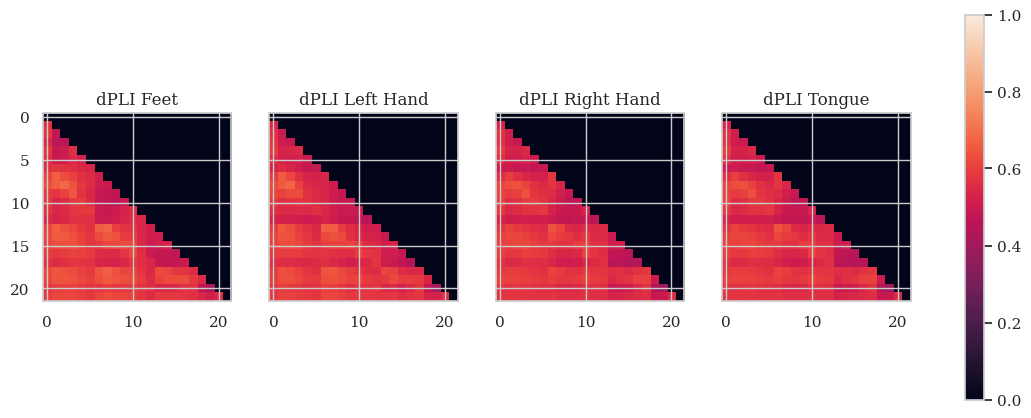

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(14, 5), sharey=True)
axs[0].imshow(conn_feet.get_data("dense"), vmin=0, vmax=1)
axs[0].set_title("dPLI Feet")

axs[1].imshow(conn_left_hand.get_data("dense"), vmin=0, vmax=1)
axs[1].set_title("dPLI Left Hand")

im = axs[2].imshow(conn_right_hand.get_data("dense"), vmin=0, vmax=1)
axs[2].set_title("dPLI Right Hand")

im = axs[3].imshow(conn_tongue.get_data("dense"), vmin=0, vmax=1)
axs[3].set_title("dPLI Tongue")

fig.colorbar(im, ax=axs.ravel())
plt.show()

In [32]:
conn_feet_np = np.squeeze(conn_feet.get_data("dense"))
conn_left_hand_np = np.squeeze(conn_left_hand.get_data("dense"))
conn_right_hand_np = np.squeeze(conn_right_hand.get_data("dense"))
conn_tongue_np = np.squeeze(conn_tongue.get_data("dense"))

EEG_Locations_list = []
print(conn_feet_np.shape, conn_left_hand_np.shape, conn_right_hand_np.shape, conn_tongue_np.shape)
for k, v in EEG_Locations.items():
	EEG_Locations_list.append(v)

EEG_Locations_list = np.array(EEG_Locations_list, dtype=float)
print(EEG_Locations_list.shape)

conn_feet_np_symm = symmetrize(conn_feet_np)
conn_left_hand_np_symm = symmetrize(conn_left_hand_np)
conn_right_hand_np_symm = symmetrize(conn_right_hand_np)
conn_tongue_np_symm = symmetrize(conn_tongue_np)

(22, 22) (22, 22) (22, 22) (22, 22)
(22, 3)


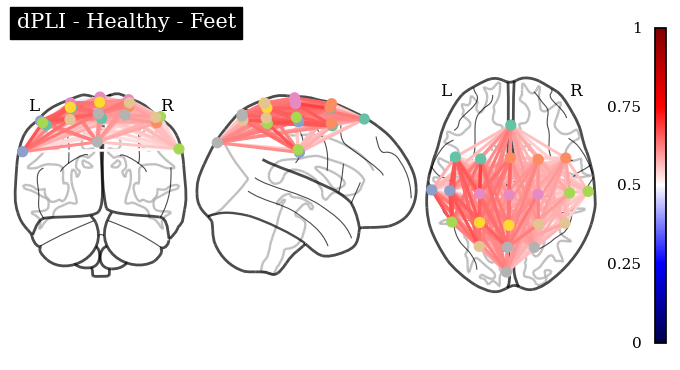

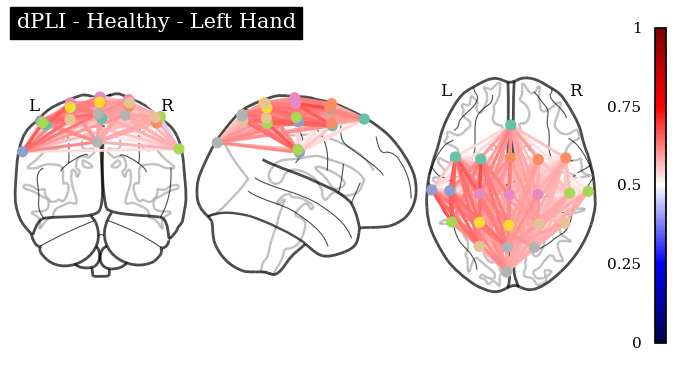

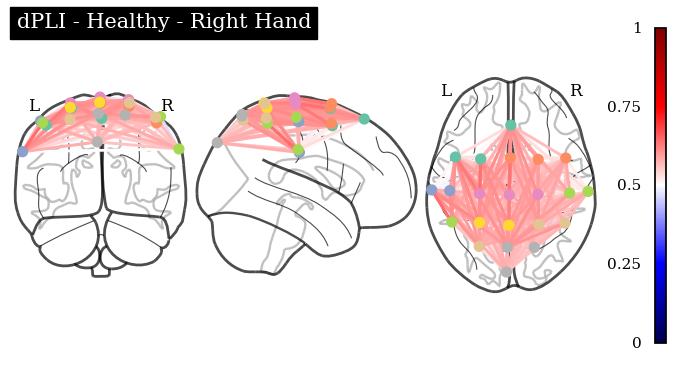

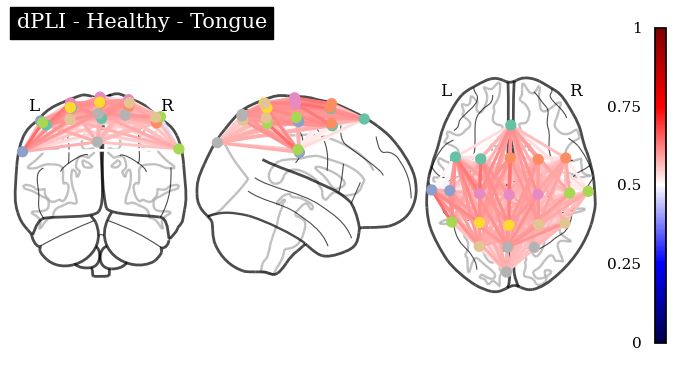

In [33]:
plotting.plot_connectome(conn_feet_np_symm, EEG_Locations_list, title="dPLI - Healthy - Feet", edge_cmap = colormaps['seismic'], edge_vmin=0, edge_vmax=1, colorbar=True)
plotting.plot_connectome(conn_left_hand_np_symm, EEG_Locations_list, title="dPLI - Healthy - Left Hand", edge_cmap = colormaps['seismic'], edge_vmin=0, edge_vmax=1, colorbar=True)
plotting.plot_connectome(conn_right_hand_np_symm, EEG_Locations_list, title="dPLI - Healthy - Right Hand", edge_cmap = colormaps['seismic'], edge_vmin=0, edge_vmax=1, colorbar=True)
plotting.plot_connectome(conn_tongue_np_symm, EEG_Locations_list, title="dPLI - Healthy - Tongue", edge_cmap = colormaps['seismic'], edge_vmin=0, edge_vmax=1, colorbar=True)

### wPLI Filtering

In [34]:
conn_feet_wpli = spectral_connectivity_epochs(
	X_feet,
	method="wpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False,
	n_jobs = 4
)

conn_left_hand_wpli = spectral_connectivity_epochs(
	X_left_hand,
	method="wpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False,
	n_jobs = 4
)

conn_right_hand_wpli = spectral_connectivity_epochs(
	X_right_hand,
	method="wpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False,
	n_jobs=4
)

conn_tongue_wpli = spectral_connectivity_epochs(
	X_right_hand,
	method="wpli",
	sfreq=250,
	fmin=8, # So we get at least 5 cycles
	fmax=30,
	faverage=True,
	verbose=False,
	n_jobs=4
)

print(conn_feet_wpli.shape, conn_left_hand_wpli.shape, conn_right_hand_wpli.shape, conn_tongue_wpli.shape)

(484, 1) (484, 1) (484, 1) (484, 1)


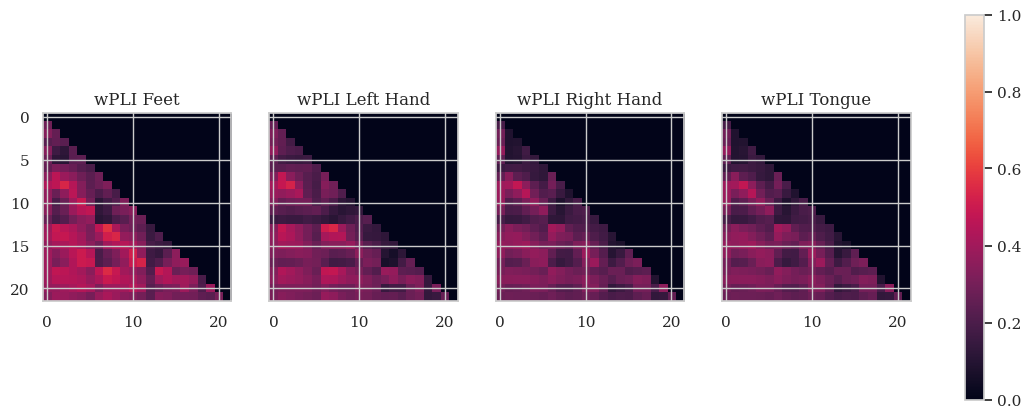

In [35]:
fig, axs = plt.subplots(1, 4, figsize=(14, 5), sharey=True)
axs[0].imshow(conn_feet_wpli.get_data("dense"), vmin=0, vmax=1)
axs[0].set_title("wPLI Feet")

axs[1].imshow(conn_left_hand_wpli.get_data("dense"), vmin=0, vmax=1)
axs[1].set_title("wPLI Left Hand")

im = axs[2].imshow(conn_right_hand_wpli.get_data("dense"), vmin=0, vmax=1)
axs[2].set_title("wPLI Right Hand")

im = axs[3].imshow(conn_tongue_wpli.get_data("dense"), vmin=0, vmax=1)
axs[3].set_title("wPLI Tongue")

fig.colorbar(im, ax=axs.ravel())
plt.show()

In [36]:
conn_feet_wpli_np = np.squeeze(conn_feet_wpli.get_data("dense"))
conn_left_hand_wpli_np = np.squeeze(conn_left_hand_wpli.get_data("dense"))
conn_right_hand_wpli_np = np.squeeze(conn_right_hand_wpli.get_data("dense"))
conn_tongue_wpli_np = np.squeeze(conn_tongue_wpli.get_data("dense"))

conn_feet_wpli_np_symm = symmetrize(conn_feet_wpli_np)
conn_left_hand_wpli_np_symm = symmetrize(conn_left_hand_wpli_np)
conn_right_hand_wpli_np_symm = symmetrize(conn_right_hand_wpli_np)
conn_tongue_wpli_np_symm = symmetrize(conn_tongue_wpli_np)


In [37]:
print((conn_feet_wpli_np > 0.5).sum())
print((conn_left_hand_wpli_np > 0.5).sum())
print((conn_right_hand_wpli_np > 0.5).sum())
print((conn_tongue_wpli_np > 0.5).sum())

9
3
0
0


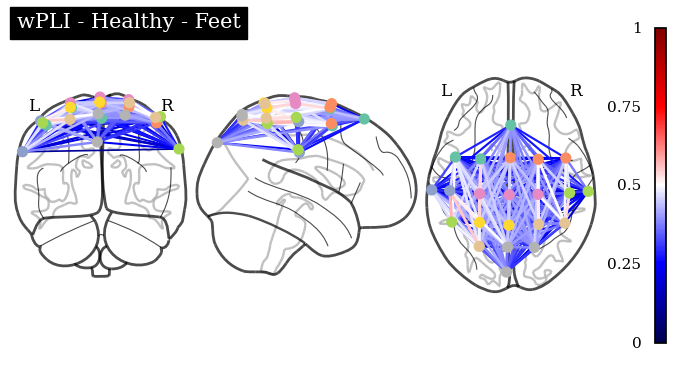

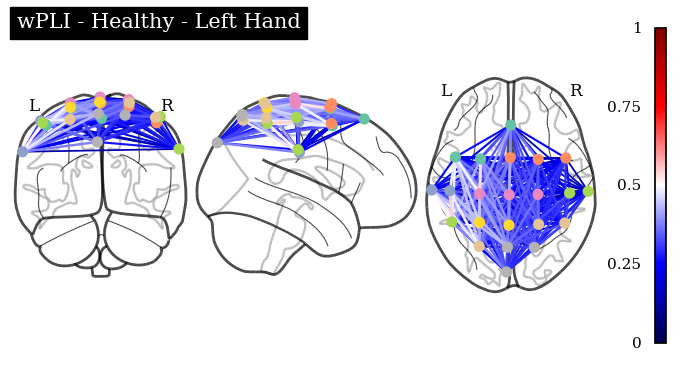

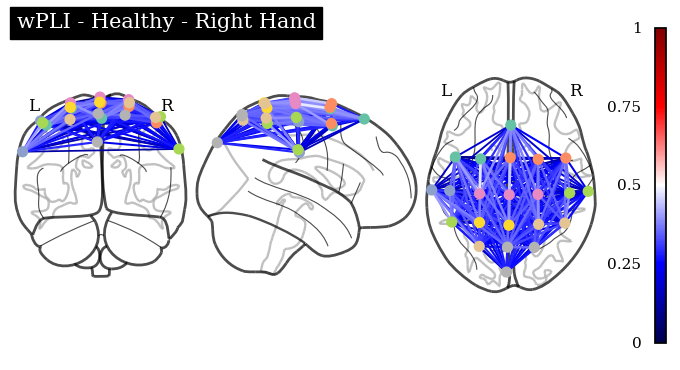

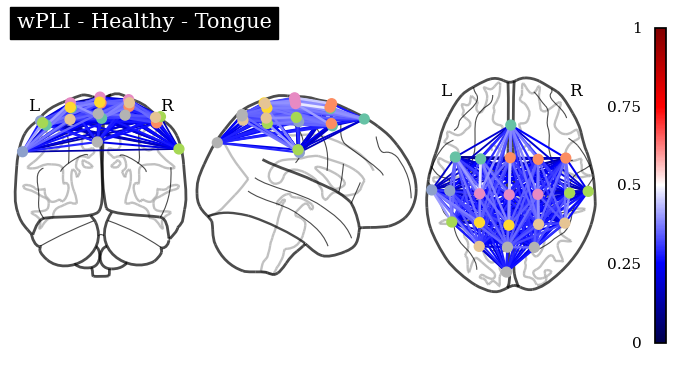

In [38]:
plotting.plot_connectome(conn_feet_wpli_np_symm, EEG_Locations_list, title="wPLI - Healthy - Feet", edge_cmap = colormaps['seismic'], edge_vmin=0, edge_vmax=1, colorbar=True)
plotting.plot_connectome(conn_left_hand_wpli_np_symm, EEG_Locations_list, title="wPLI - Healthy - Left Hand", edge_cmap = colormaps['seismic'], edge_vmin=0, edge_vmax=1, colorbar=True)
plotting.plot_connectome(conn_right_hand_wpli_np_symm, EEG_Locations_list, title="wPLI - Healthy - Right Hand", edge_cmap = colormaps['seismic'], edge_vmin=0, edge_vmax=1, colorbar=True)
plotting.plot_connectome(conn_tongue_wpli_np_symm, EEG_Locations_list, title="wPLI - Healthy - Tongue", edge_cmap = colormaps['seismic'], edge_vmin=0, edge_vmax=1, colorbar=True)

In [41]:
subjects = [1]
with warnings.catch_warnings(action="ignore"):
	epochs, y, metadata = paradigm.get_data(dataset=datasetMotorImagery, subjects=subjects, return_epochs=True)


Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied


In [42]:
print(epochs.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG
 custom_ref_applied: False
 dig: 25 items (3 Cardinal, 22 EEG)
 highpass: 8.0 Hz
 lowpass: 32.0 Hz
 meas_date: unspecified
 nchan: 22
 projs: []
 sfreq: 250.0 Hz
>


In [46]:
# Now, visualize the connectivity in 3D:
mne.viz.set_3d_backend("notebook")
plot_sensors_connectivity(epochs.info, conn_feet_wpli.get_data(output="dense")[:, :, 0])

Using notebook 3d backend.



RuntimeError: Using the notebook backend on Linux requires a compatible VTK setup. Consider using Xfvb or xvfb-run to set up a working virtual display, or install VTK with OSMesa enabled.